# HR Overtime Prediction and Forecasting
## Predicción y Pronóstico de Horas Extra de RRHH

Los componentes principales incluyen:

* Carga de datos históricos desde SQL Server con manejo de datos faltantes mediante interpolación.
* Análisis exploratorio con gráficas ACF/PACF y detección automática del período estacional.
* Preprocesamiento para garantizar estacionariedad (transformaciones logarítmicas o diferenciación) y detección de outliers con filtrado de Hampel.
* Entrenamiento de modelos SARIMA con selección automática de parámetros, validación cruzada para series temporales, y diagnóstico de residuos.
* Generación de predicciones con intervalos de confianza.
* Visualización interactiva con Plotly para datos históricos y pronósticos.
* Almacenamiento de modelos, predicciones, y métricas en SQL Server.

Objetivo: Producir pronósticos precisos y robustos de horas extra por departamento, minimizando la intervención manual y asegurando la calidad del modelo.

## 1. Importar Librerías y Configuración

Importamos las librerías necesarias para análisis, modelado, visualización, y conexión con la base de datos. Configuramos logging para trazabilidad y suprimimos advertencias innecesarias.

In [9]:
import pandas as pd
import numpy as np
import pymssql
import logging
import datetime
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import median_abs_deviation
from scipy.signal import correlate
import joblib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configurar advertencias y logging
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('overtime_forecast.log')
    ]
)

## 2. Conectar a la Base de Datos
Establecemos una conexión segura a SQL Server para cargar datos históricos y almacenar resultados.

In [10]:
def get_db_connection():

    SQL_SERVER = "172.28.192.1:50121"
    SQL_DB = "HR_Analytics"
    SQL_USER = "sa"
    SQL_PASSWORD = "123456"
    try:
        conn = pymssql.connect(
            server=SQL_SERVER,
            database=SQL_DB,
            user=SQL_USER,
            password=SQL_PASSWORD
        )
        logging.info("Conexión a la base de datos exitosa")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión a la base de datos: {e}")
        raise

## 3. Cargar y Procesar Datos Históricos

Cargamos los datos históricos, manejamos datos faltantes con interpolación, aplicamos preprocesamiento para estacionariedad, y detectamos outliers con el filtrado de Hampel.

In [11]:
def detect_outliers(dept_data):
    """
    Detecta y trata outliers en la columna total_overtime usando el método IQR.

    Args:
        dept_data (pd.DataFrame): Datos del departamento con columna total_overtime.

    Returns:
        pd.DataFrame: Datos con outliers reemplazados por la mediana.
    """
    Q1 = dept_data['total_overtime'].quantile(0.25)
    Q3 = dept_data['total_overtime'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = dept_data[(dept_data['total_overtime'] < lower_bound) | (dept_data['total_overtime'] > upper_bound)]
    if not outliers.empty:
        logging.warning(f"Outliers detectados en {dept_data['department'].iloc[0]}:\n{outliers}")
        dept_data['total_overtime'] = np.where(
            (dept_data['total_overtime'] < lower_bound) | (dept_data['total_overtime'] > upper_bound),
            dept_data['total_overtime'].median(),
            dept_data['total_overtime']
        )
    return dept_data

def load_historical_data():
    """
    Carga datos históricos desde SQL Server y realiza preprocesamiento.

    Returns:
        pd.DataFrame: Datos históricos limpios y procesados.
    """
    conn = get_db_connection()
    query = "SELECT work_date, department, total_overtime FROM vw_historical_data ORDER BY work_date, department ASC"
    
    try:
        df = pd.read_sql(query, conn)
        logging.info(f"Datos cargados: {len(df)} registros")
        
        # Verificar datos nulos
        print("Valores nulos:\n", df.isnull().sum())
        df['total_overtime'] = df['total_overtime'].fillna(df['total_overtime'].median())
        
        # Convertir work_date a datetime
        df['work_date'] = pd.to_datetime(df['work_date']).dt.date
        df['work_date'] = pd.to_datetime(df['work_date'])
        
        # Verificar duplicados
        print("Duplicados:", df.duplicated(subset=['work_date', 'department']).sum())
        df = df.drop_duplicates(subset=['work_date', 'department'])
        
        # Tratar outliers por departamento
        for department in df['department'].unique():
            dept_data = df[df['department'] == department].copy()
            df.loc[dept_data.index, 'total_overtime'] = detect_outliers(dept_data)['total_overtime']
        
        print("Resumen de datos:")
        print("Departamentos únicos:", df['department'].unique())
        print("Fechas únicas:", sorted(df['work_date'].unique()))
        print("Total registros:", len(df))
        
        return df
    
    finally:
        conn.close()

# Cargar y mostrar datos
historical_data = load_historical_data()
print("\nMuestra de datos históricos:")
display(historical_data.tail(12).sort_values(by=['work_date', 'department'], ascending=False))

2025-05-23 20:07:25,398 - INFO - Conexión a la base de datos exitosa
2025-05-23 20:07:27,615 - INFO - Datos cargados: 318 registros


Valores nulos:
 work_date         0
department        0
total_overtime    0
dtype: int64
Duplicados: 0


2025-05-23 20:07:28,374 - WARNING - Outliers detectados en Inventory:
     work_date department  total_overtime
212 2025-01-19  Inventory           14.71
290 2025-04-20  Inventory           17.93
2025-05-23 20:07:28,393 - WARNING - Outliers detectados en IT:
     work_date department  total_overtime
303 2025-05-04         IT           19.78
2025-05-23 20:07:28,406 - WARNING - Outliers detectados en Marketing:
     work_date department  total_overtime
286 2025-04-13  Marketing           20.43


Resumen de datos:
Departamentos únicos: ['Finance' 'HR' 'Inventory' 'IT' 'Marketing' 'Sales']
Fechas únicas: [Timestamp('2024-05-19 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2024-06-09 00:00:00'), Timestamp('2024-06-16 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-07-07 00:00:00'), Timestamp('2024-07-14 00:00:00'), Timestamp('2024-07-21 00:00:00'), Timestamp('2024-07-28 00:00:00'), Timestamp('2024-08-04 00:00:00'), Timestamp('2024-08-11 00:00:00'), Timestamp('2024-08-18 00:00:00'), Timestamp('2024-08-25 00:00:00'), Timestamp('2024-09-01 00:00:00'), Timestamp('2024-09-08 00:00:00'), Timestamp('2024-09-15 00:00:00'), Timestamp('2024-09-22 00:00:00'), Timestamp('2024-09-29 00:00:00'), Timestamp('2024-10-06 00:00:00'), Timestamp('2024-10-13 00:00:00'), Timestamp('2024-10-20 00:00:00'), Timestamp('2024-10-27 00:00:00'), Timestamp('2024-11-03 00:00:00'), Timestamp('2024-11-10 00:00:00'), Timest

,work_date,department,total_overtime
317,2025-05-18,Sales,1.57
316,2025-05-18,Marketing,3.49
314,2025-05-18,Inventory,2.89
315,2025-05-18,IT,1.13
313,2025-05-18,HR,1.92
312,2025-05-18,Finance,1.60
311,2025-05-11,Sales,0.00
310,2025-05-11,Marketing,1.99
308,2025-05-11,Inventory,8.03
309,2025-05-11,IT,12.85


## 4. Análisis Exploratorio: ACF, PACF, Estacionariedad y Estacionalidad

Realizamos un análisis exploratorio para verificar estacionariedad y detectar el período estacional automáticamente.

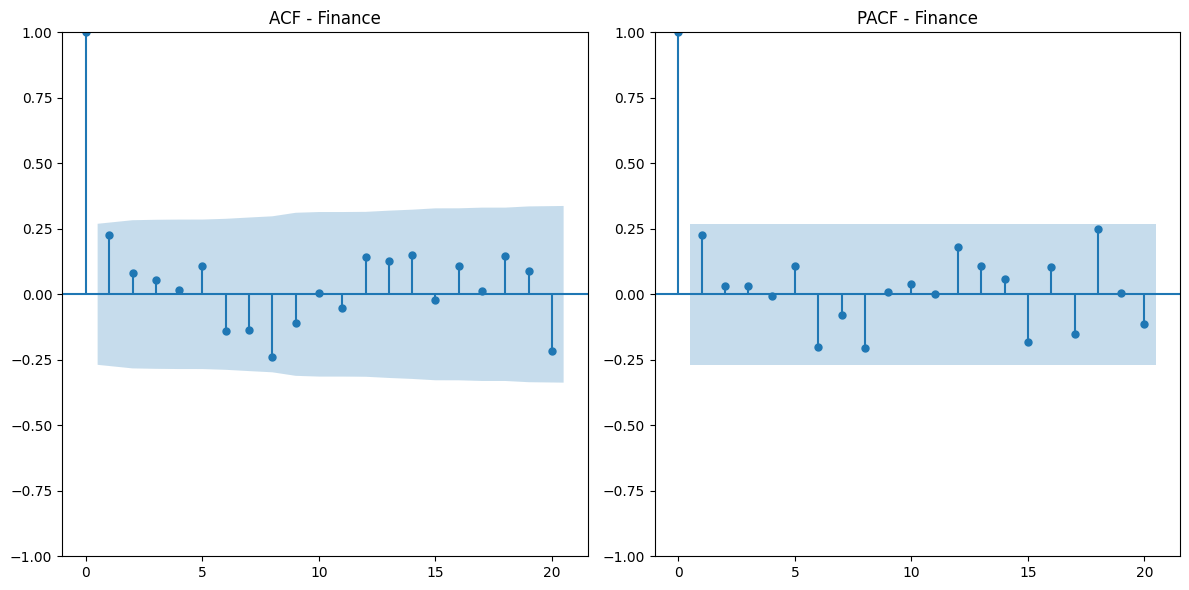

2025-05-23 20:07:33,312 - INFO - Período estacional detectado: 8



Análisis de Estacionariedad para Finance
Test Statistic: -5.567976
p-value: 0.000001
Critical Values: {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}

Conclusión:
Datos estacionarios
Período estacional detectado para Finance: 8


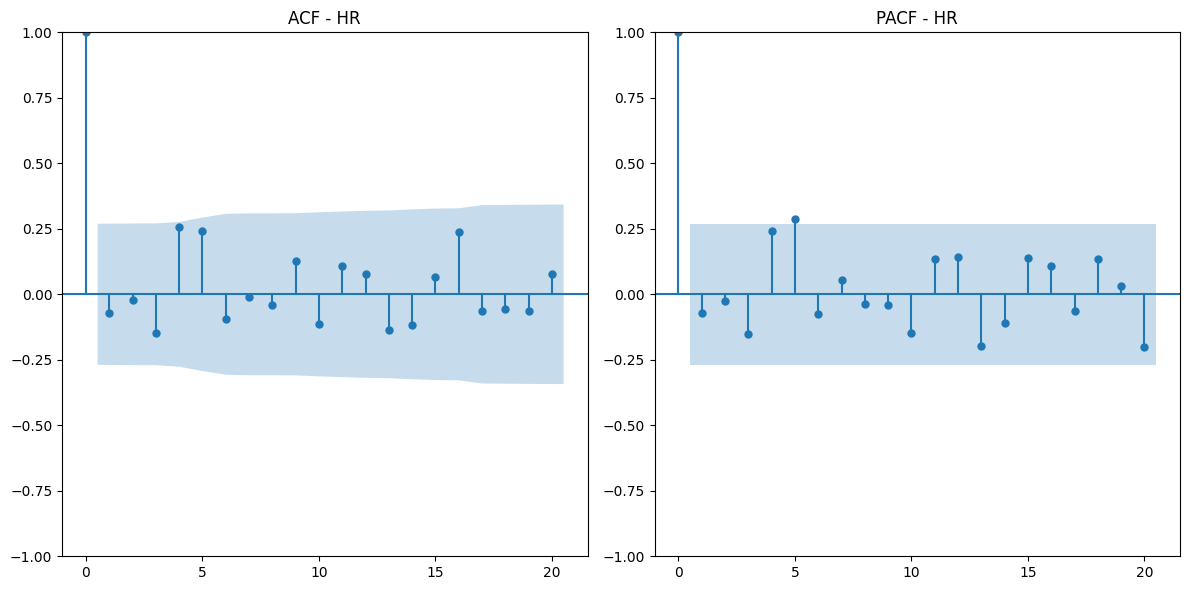

2025-05-23 20:07:34,516 - INFO - Período estacional detectado: 3



Análisis de Estacionariedad para HR
Test Statistic: -4.898444
p-value: 0.000035
Critical Values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}

Conclusión:
Datos estacionarios
Período estacional detectado para HR: 3


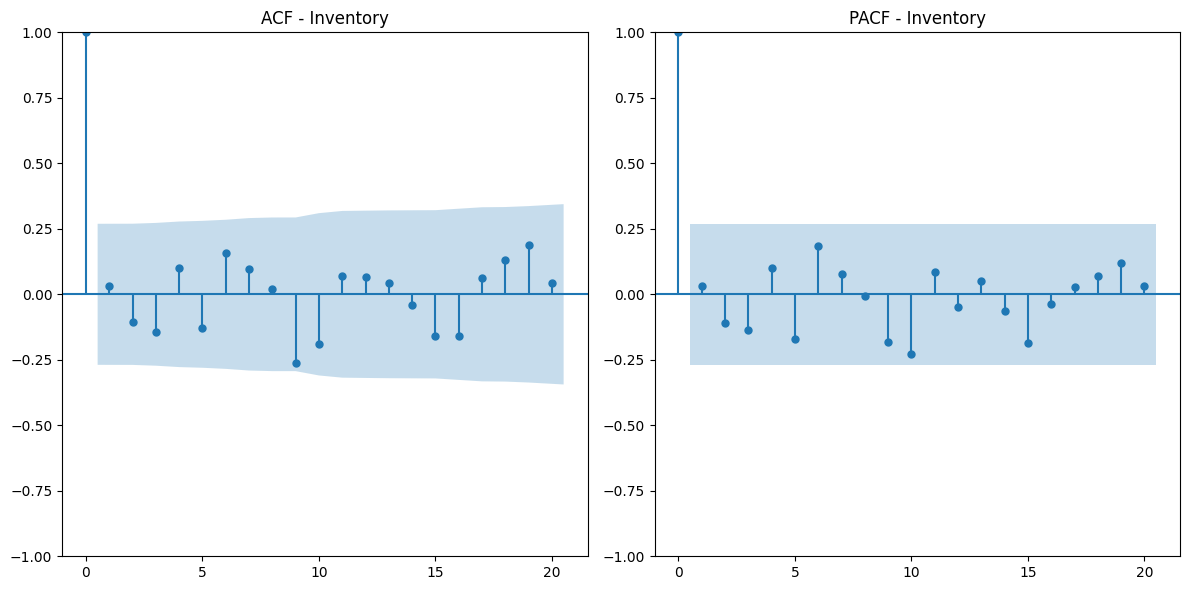

2025-05-23 20:07:35,387 - INFO - Período estacional detectado: 9



Análisis de Estacionariedad para Inventory
Test Statistic: -6.812109
p-value: 0.000000
Critical Values: {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}

Conclusión:
Datos estacionarios
Período estacional detectado para Inventory: 9


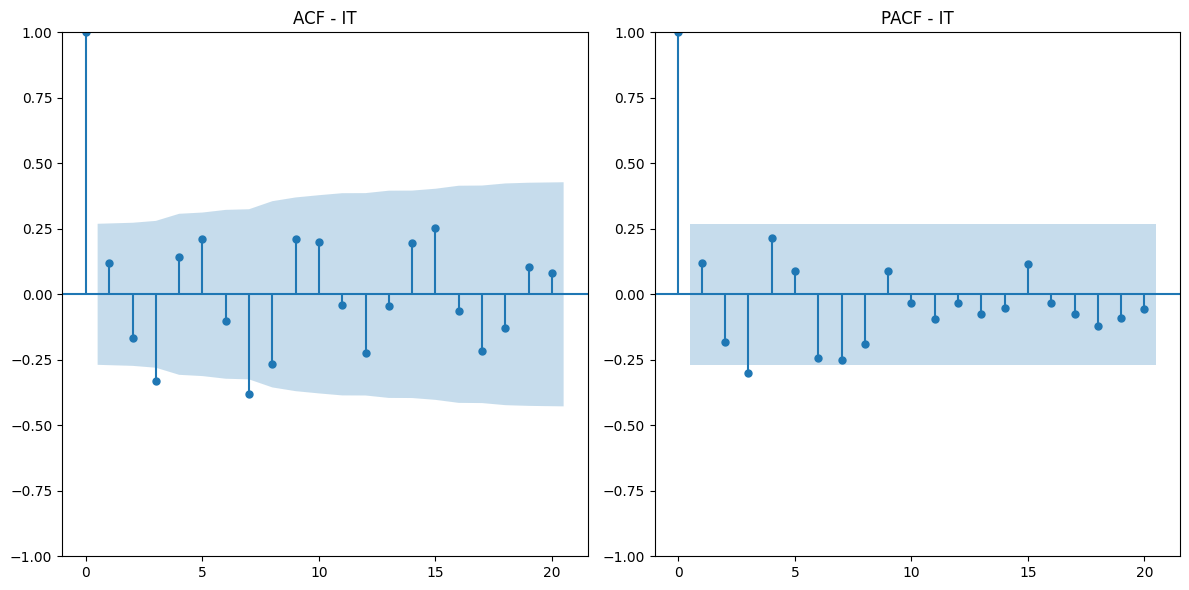

2025-05-23 20:07:36,287 - INFO - Período estacional detectado: 7



Análisis de Estacionariedad para IT
Test Statistic: -3.818299
p-value: 0.002726
Critical Values: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}

Conclusión:
Datos estacionarios
Período estacional detectado para IT: 7


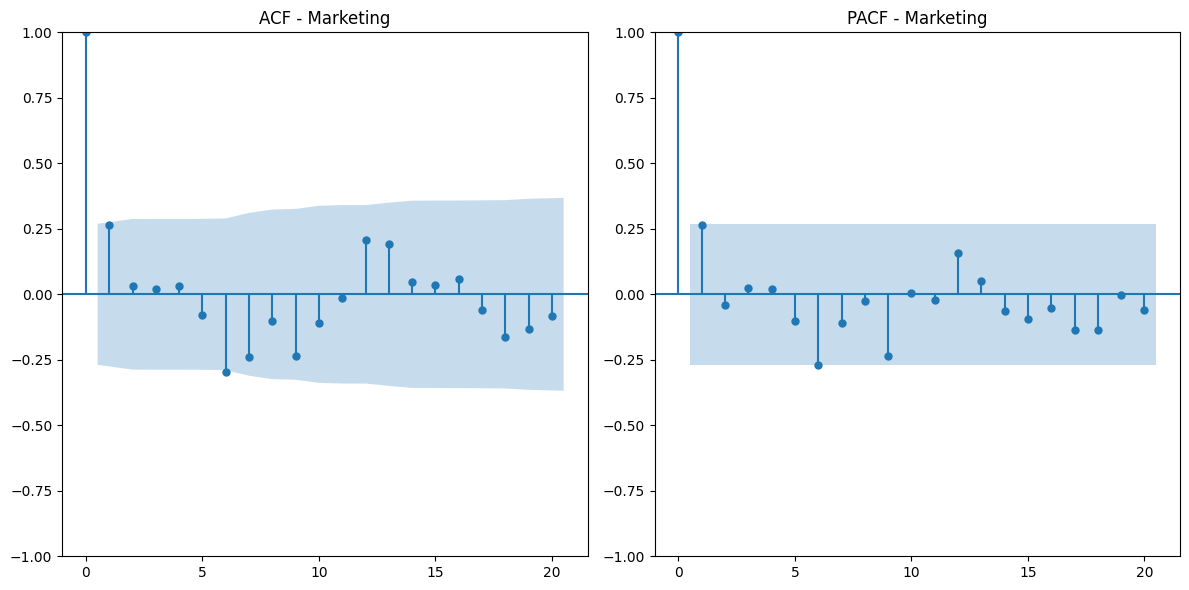

2025-05-23 20:07:38,193 - INFO - Período estacional detectado: 6



Análisis de Estacionariedad para Marketing
Test Statistic: -5.351943
p-value: 0.000004
Critical Values: {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}

Conclusión:
Datos estacionarios
Período estacional detectado para Marketing: 6


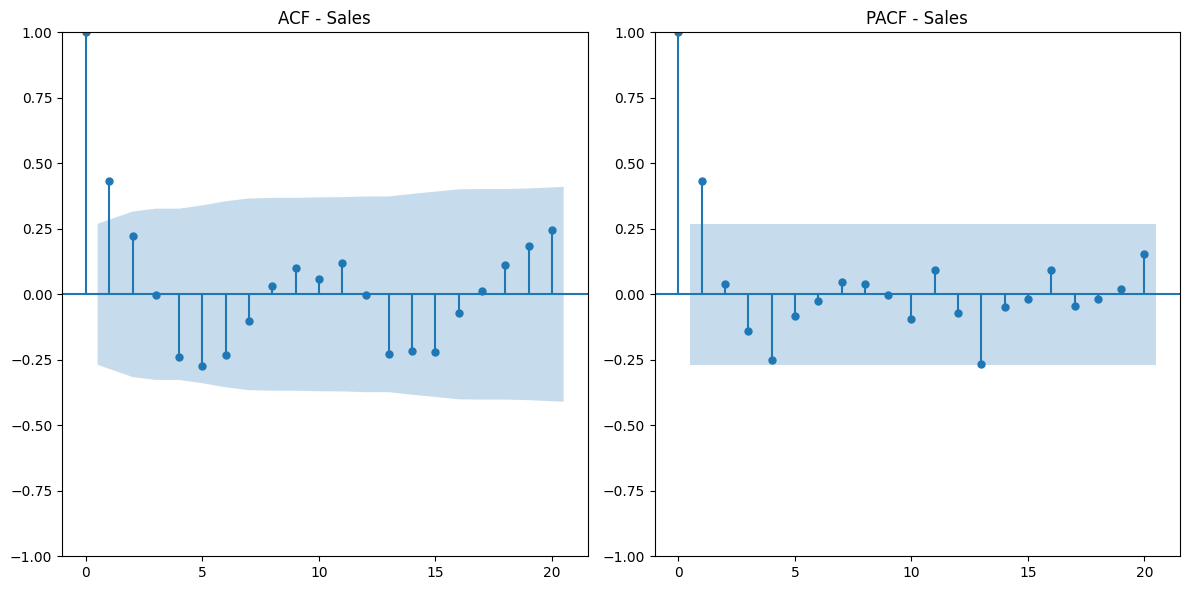

2025-05-23 20:07:38,864 - INFO - Período estacional detectado: 1



Análisis de Estacionariedad para Sales
Test Statistic: -3.986926
p-value: 0.001481
Critical Values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}

Conclusión:
Datos estacionarios
Período estacional detectado para Sales: 1

Resumen de Estacionariedad por Departamento:


,department,test_statistic,p_value,is_stationary
0,Finance,-5.567976,1.489681e-06,True
1,HR,-4.898444,3.511837e-05,True
2,Inventory,-6.812109,2.103454e-09,True
3,IT,-3.818299,2.725542e-03,True
4,Marketing,-5.351943,4.270192e-06,True
5,Sales,-3.986926,1.480539e-03,True


In [12]:
def plot_acf_pacf(data, department, lags=20):
    """
    Genera y muestra las gráficas ACF y PACF para un departamento.

    Args:
        data (pd.DataFrame): Datos del departamento con índice temporal.
        department (str): Nombre del departamento.
        lags (int): Número de lags a mostrar.
    """
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    plot_acf(data['total_overtime'].dropna(), lags=lags, ax=plt.gca(), title=f'ACF - {department}')
    
    plt.subplot(122)
    plot_pacf(data['total_overtime'].dropna(), lags=lags, ax=plt.gca(), title=f'PACF - {department}')
    
    plt.tight_layout()
    plt.show()

def check_stationarity(dept_data, department):
    """
    Realiza la prueba de Dickey-Fuller para verificar estacionariedad.

    Args:
        dept_data (pd.DataFrame): Datos del departamento con índice temporal.
        department (str): Nombre del departamento.

    Returns:
        dict: Resultados de la prueba.
    """
    series = dept_data['total_overtime'].dropna()
    result = adfuller(series)
    print(f"\nAnálisis de Estacionariedad para {department}")
    print(f"Test Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values: {result[4]}")
    
    is_stationary = result[1] < 0.05
    print("\nConclusión:")
    print("Datos estacionarios" if is_stationary else "Datos no estacionarios")
    
    return {
        'department': department,
        'test_statistic': result[0],
        'p_value': result[1],
        'is_stationary': is_stationary
    }

def detect_seasonal_period(data, max_lags=20):
    """
    Detecta el período estacional analizando los picos en la ACF.

    Args:
        data (pd.Series): Serie temporal.
        max_lags (int): Número máximo de lags a analizar.

    Returns:
        int: Período estacional detectado (o 1 si no hay estacionalidad).
    """
    try:
        series = data.dropna()
        if len(series) < max_lags:
            max_lags = len(series) // 2
        acf_values, confint = acf(series, nlags=max_lags, alpha=0.05, fft=False)
        significant_lags = []
        
        for lag in range(1, max_lags + 1):
            if abs(acf_values[lag]) > confint[lag, 1] / 1.96:
                significant_lags.append((lag, abs(acf_values[lag])))
        
        if significant_lags:
            seasonal_period = max(significant_lags, key=lambda x: x[1])[0]
            logging.info(f"Período estacional detectado: {seasonal_period}")
            return seasonal_period
        else:
            logging.info("No se detectó estacionalidad clara, usando m=1")
            return 1
    except Exception as e:
        logging.error(f"Error detectando período estacional: {e}")
        return 1

# Ejecutar análisis exploratorio
stationarity_results = []
for department in historical_data['department'].unique():
    dept_data = historical_data[historical_data['department'] == department].set_index('work_date')
    plot_acf_pacf(dept_data, department)
    stationarity_results.append(check_stationarity(dept_data, department))
    seasonal_period = detect_seasonal_period(dept_data['total_overtime'])
    print(f"Período estacional detectado para {department}: {seasonal_period}")

# Resumen de estacionariedad
stationarity_df = pd.DataFrame(stationarity_results)
print("\nResumen de Estacionariedad por Departamento:")
display(stationarity_df)

## 5. Entrenamiento y Validación del Modelo SARIMA

Entrenamos modelos SARIMA con períodos estacionales detectados automáticamente, validamos residuos, y realizamos validación cruzada.

Matriz de correlación entre departamentos:


department,Finance,HR,IT,Inventory,Marketing,Sales
department,,,,,,
Finance,1.000000,0.148779,0.155797,0.105404,-0.216644,0.027948
HR,0.148779,1.000000,0.249238,0.232039,0.085274,-0.083724
IT,0.155797,0.249238,1.000000,-0.094430,-0.101645,0.052147
Inventory,0.105404,0.232039,-0.094430,1.000000,0.047260,-0.133923
Marketing,-0.216644,0.085274,-0.101645,0.047260,1.000000,-0.020145
Sales,0.027948,-0.083724,0.052147,-0.133923,-0.020145,1.000000


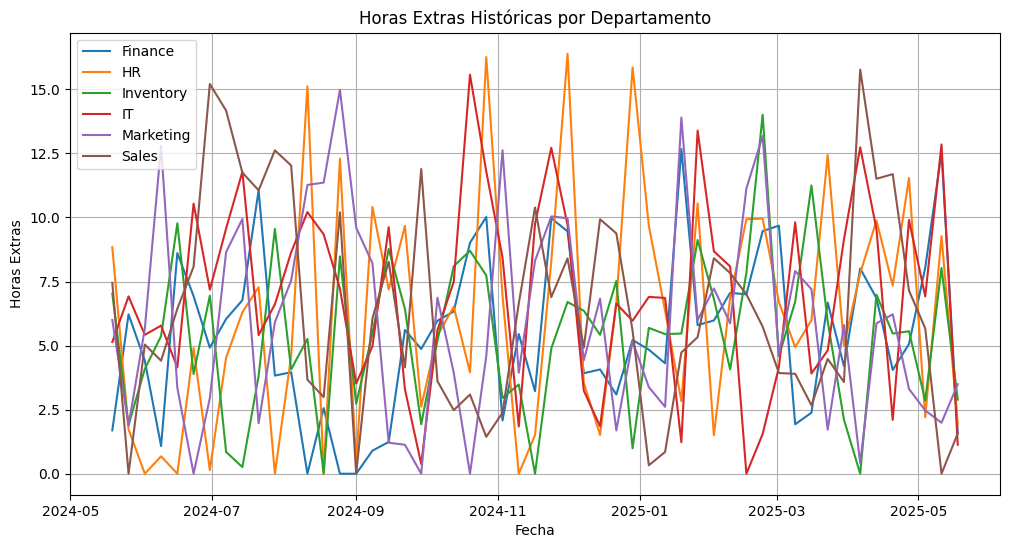

2025-05-23 20:07:40,944 - INFO - Serie corta (53 puntos). Limitando período estacional a 4.
2025-05-23 20:07:40,973 - INFO - Período estacional seleccionado: 13 (std estacional: 1.6280)


Período estacional para Finance: 13


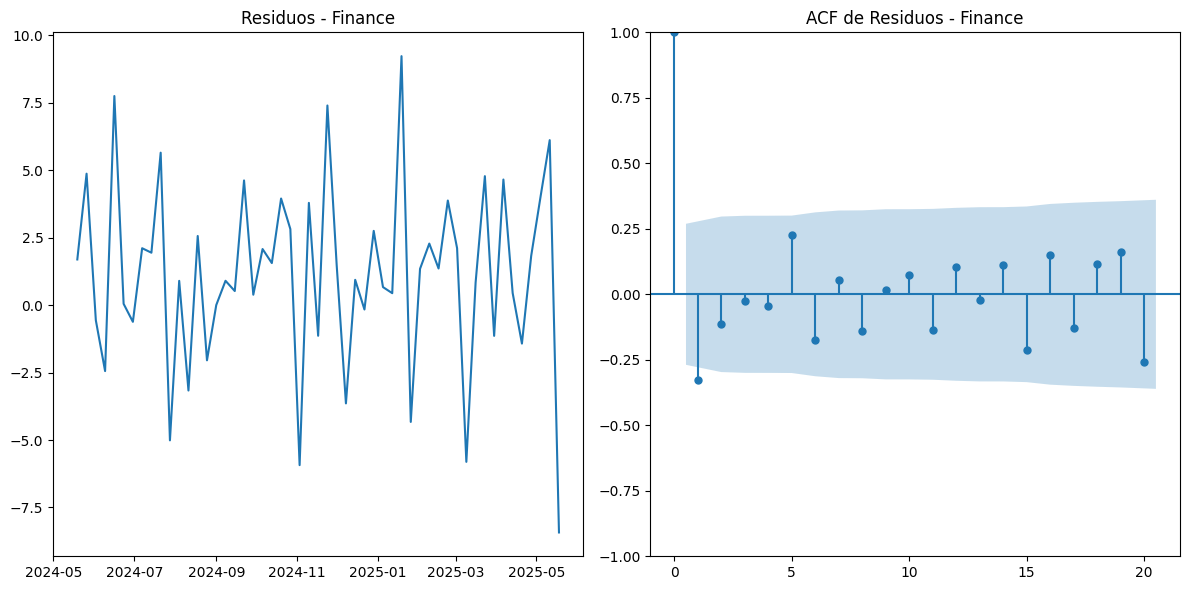

Prueba de Ljung-Box para Finance:
      lb_stat  lb_pvalue
10  13.799948   0.182314
Validación cruzada para Finance (SARIMA):
RMSE medio: 4.62, MAE medio: 3.64
Departamento: Finance
Última fecha histórica: 2025-05-18 00:00:00
Primera fecha de pronóstico: 2025-05-25 00:00:00
Fechas históricas (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Fechas de historical_pred (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', freq='W-SUN') ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', freq='W-SUN')
Últimos 5 valores de series: work_date
2025-04-20     4.05
2025-04-27     5.06
2025-05-04     8.04
2025-05-11    12.54
2025-05-18     1.60
Name: total_overtime, dtype: float64
Últimos 5 valores de historical

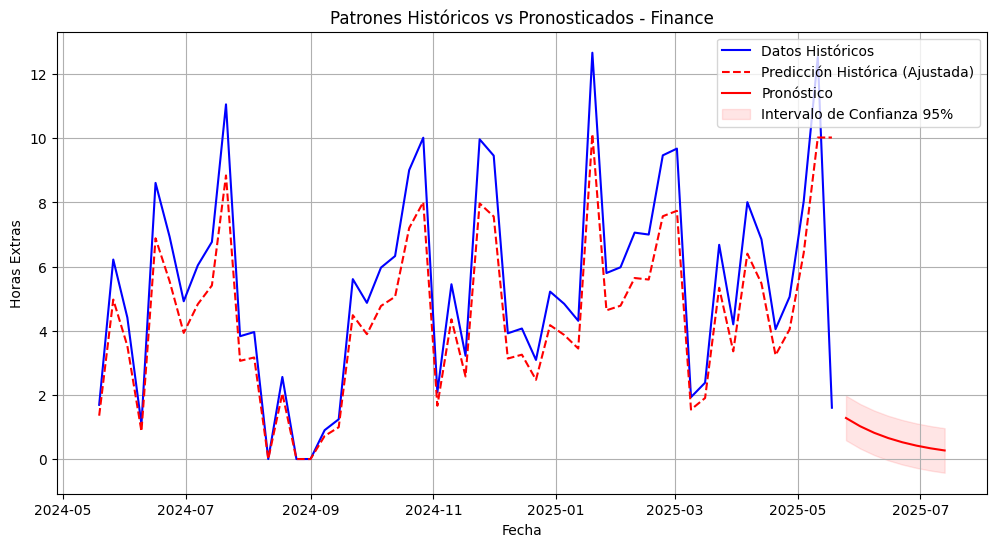

2025-05-23 20:07:49,370 - INFO - Serie corta (53 puntos). Limitando período estacional a 4.
2025-05-23 20:07:49,383 - INFO - Período estacional seleccionado: 4 (std estacional: 1.8847)


Desplazamiento temporal (lags) para Finance: 0 semanas
Correlación máxima: 382.28331747044115
Modelo entrenado para Finance: sarima
Orden: (1, 0, 0), Orden Estacional: (0, 0, 0, 13)

Período estacional para HR: 4


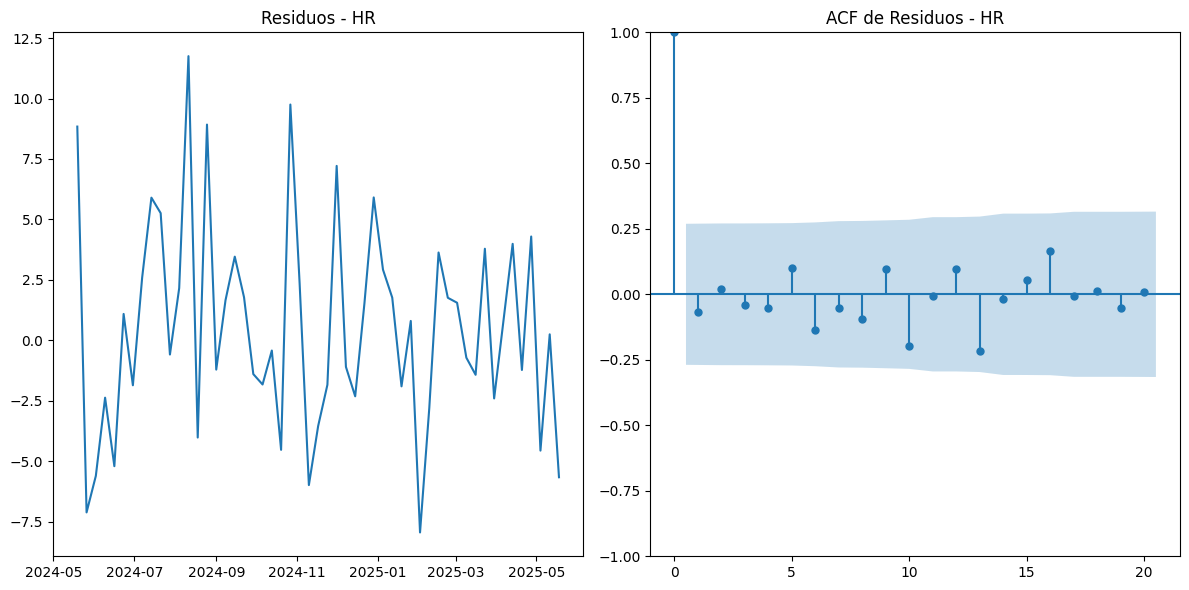

Prueba de Ljung-Box para HR:
     lb_stat  lb_pvalue
10  6.325206   0.787241
Validación cruzada para HR (SARIMA):
RMSE medio: 4.55, MAE medio: 3.83
Departamento: HR
Última fecha histórica: 2025-05-18 00:00:00
Primera fecha de pronóstico: 2025-05-25 00:00:00
Fechas históricas (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Fechas de historical_pred (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', freq='W-SUN') ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', freq='W-SUN')
Últimos 5 valores de series: work_date
2025-04-20     7.34
2025-04-27    11.54
2025-05-04     2.20
2025-05-11     9.27
2025-05-18     1.92
Name: total_overtime, dtype: float64
Últimos 5 valores de historical_pred (original):

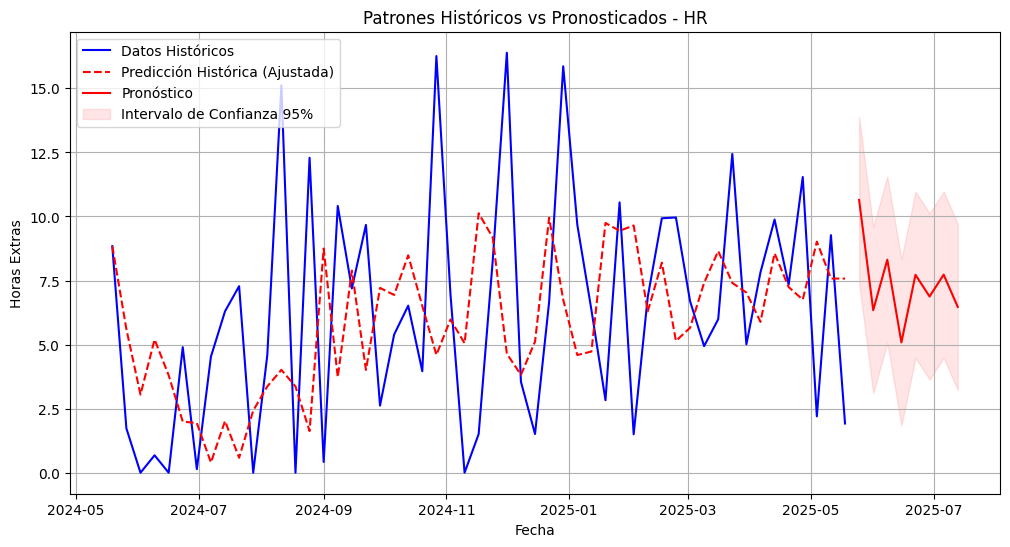

2025-05-23 20:08:07,100 - INFO - Serie corta (53 puntos). Limitando período estacional a 4.
2025-05-23 20:08:07,117 - INFO - Período estacional seleccionado: 13 (std estacional: 1.8175)


Desplazamiento temporal (lags) para HR: -3 semanas
Correlación máxima: 450.7731497102388
Modelo entrenado para HR: sarima
Orden: (3, 1, 1), Orden Estacional: (0, 0, 0, 4)

Período estacional para Inventory: 13


2025-05-23 20:08:11,952 - WARNING - Orden nulo detectado para Inventory. Usando Holt.


Validación cruzada para Inventory (Holt):
RMSE medio: 3.61, MAE medio: 3.03
Departamento: Inventory
Última fecha histórica: 2025-05-18 00:00:00
Primera fecha de pronóstico: 2025-05-25 00:00:00
Fechas históricas (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Fechas de historical_pred (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Últimos 5 valores de series: work_date
2025-04-20    5.47
2025-04-27    5.56
2025-05-04    2.85
2025-05-11    8.03
2025-05-18    2.89
Name: total_overtime, dtype: float64
Últimos 5 valores de historical_pred (original): work_date
2025-04-20    3.244602
2025-0

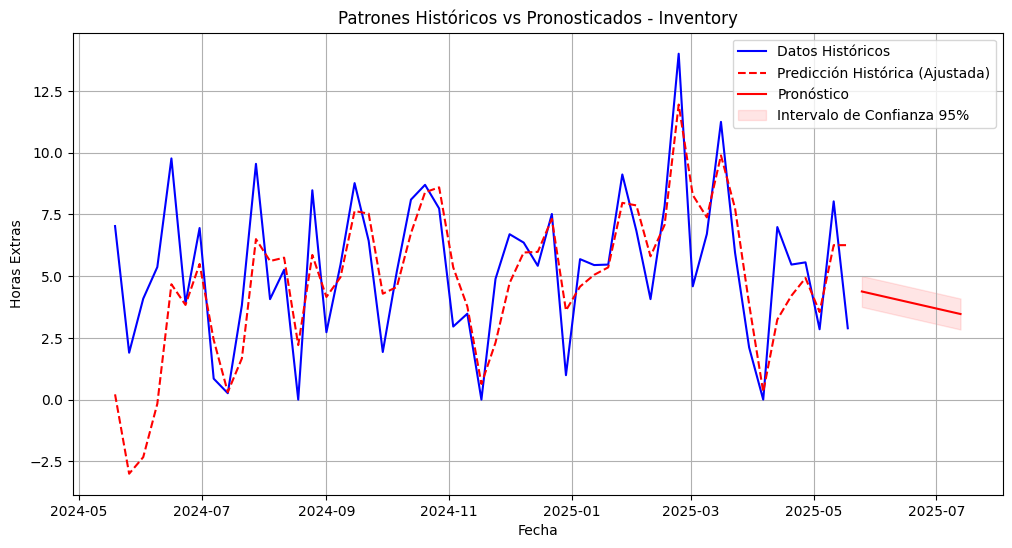

2025-05-23 20:08:12,846 - INFO - Serie corta (53 puntos). Limitando período estacional a 4.
2025-05-23 20:08:12,856 - INFO - Período estacional seleccionado: 13 (std estacional: 1.7436)


Desplazamiento temporal (lags) para Inventory: 0 semanas
Correlación máxima: 313.3396399156879
Modelo entrenado para Inventory: holt
Orden: None, Orden Estacional: None

Período estacional para IT: 13


2025-05-23 20:08:16,708 - WARNING - Orden nulo detectado para IT. Usando Holt.


Validación cruzada para IT (Holt):
RMSE medio: 6.32, MAE medio: 5.57
Departamento: IT
Última fecha histórica: 2025-05-18 00:00:00
Primera fecha de pronóstico: 2025-05-25 00:00:00
Fechas históricas (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Fechas de historical_pred (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Últimos 5 valores de series: work_date
2025-04-20     2.10
2025-04-27     9.90
2025-05-04     6.92
2025-05-11    12.85
2025-05-18     1.13
Name: total_overtime, dtype: float64
Últimos 5 valores de historical_pred (original): work_date
2025-04-20    9.237398
2025-04-27    7

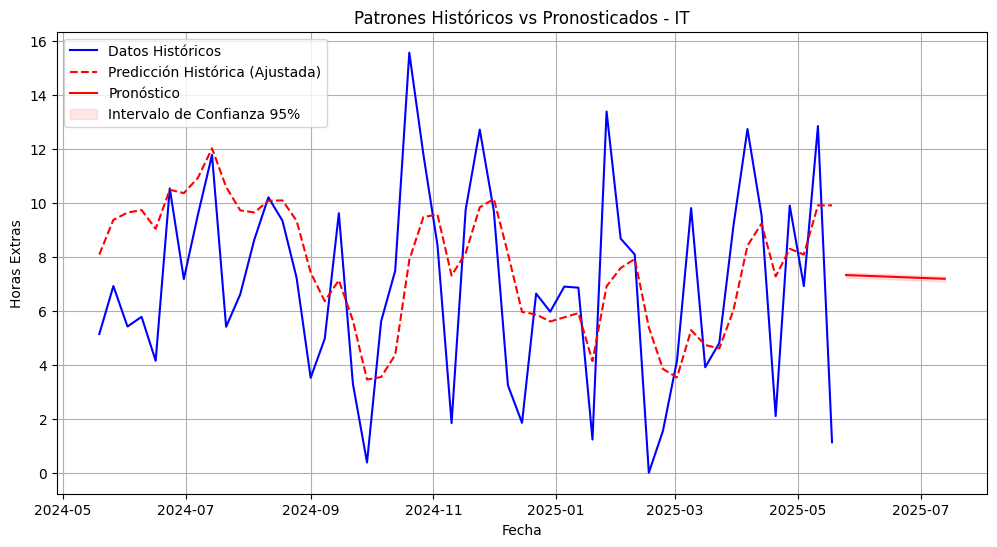

2025-05-23 20:08:17,519 - INFO - Serie corta (53 puntos). Limitando período estacional a 4.
2025-05-23 20:08:17,532 - INFO - Período estacional seleccionado: 13 (std estacional: 2.1562)


Desplazamiento temporal (lags) para IT: -1 semanas
Correlación máxima: 223.81953234795
Modelo entrenado para IT: holt
Orden: None, Orden Estacional: None

Período estacional para Marketing: 13


2025-05-23 20:08:21,449 - WARNING - Residuos no son ruido blanco para Marketing (p-valor=0.0437)
2025-05-23 20:08:21,454 - INFO - Reintentando con parámetros más amplios para Marketing
2025-05-23 20:10:04,416 - WARNING - Residuos no son ruido blanco para Marketing (p-valor=0.0437)
2025-05-23 20:10:04,417 - WARNING - SARIMA no válido para Marketing, usando Holt


Validación cruzada para Marketing (Holt):
RMSE medio: 6.00, MAE medio: 5.27
Departamento: Marketing
Última fecha histórica: 2025-05-18 00:00:00
Primera fecha de pronóstico: 2025-05-25 00:00:00
Fechas históricas (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Fechas de historical_pred (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Últimos 5 valores de series: work_date
2025-04-20    6.22
2025-04-27    3.31
2025-05-04    2.47
2025-05-11    1.99
2025-05-18    3.49
Name: total_overtime, dtype: float64
Últimos 5 valores de historical_pred (original): work_date
2025-04-20    3.687628
2025-0

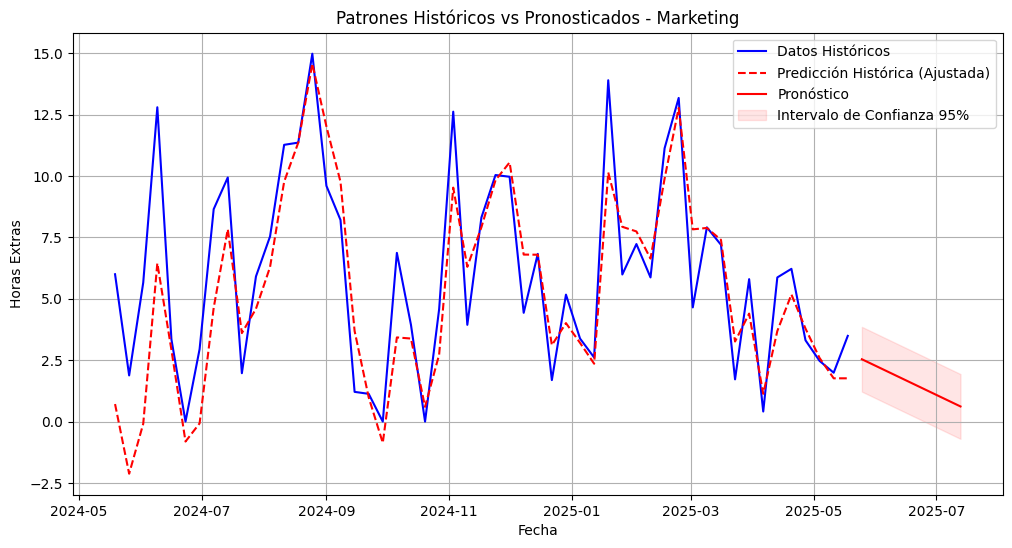

2025-05-23 20:10:05,383 - INFO - Serie corta (53 puntos). Limitando período estacional a 4.
2025-05-23 20:10:05,398 - INFO - Período estacional seleccionado: 13 (std estacional: 1.6428)


Desplazamiento temporal (lags) para Marketing: 0 semanas
Correlación máxima: 676.91704211866
Modelo entrenado para Marketing: holt
Orden: None, Orden Estacional: None

Período estacional para Sales: 13


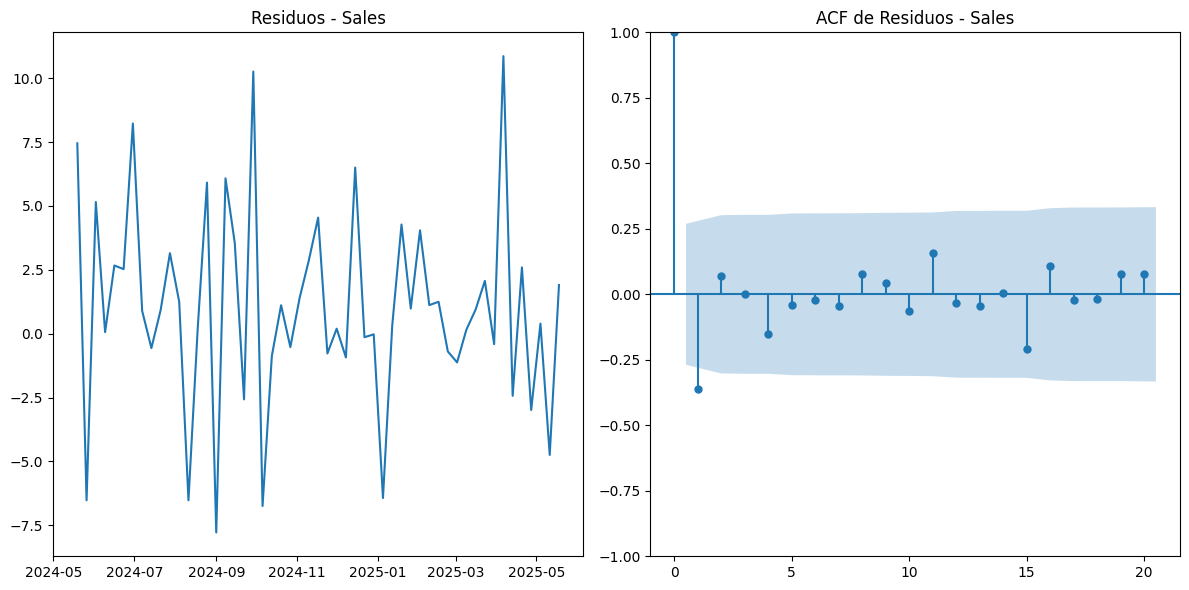

Prueba de Ljung-Box para Sales:
     lb_stat  lb_pvalue
10  9.979331   0.442308
Validación cruzada para Sales (SARIMA):
RMSE medio: 4.74, MAE medio: 3.93
Departamento: Sales
Última fecha histórica: 2025-05-18 00:00:00
Primera fecha de pronóstico: 2025-05-25 00:00:00
Fechas históricas (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', name='work_date', freq=None) ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', name='work_date', freq=None)
Fechas de historical_pred (primeras 3 y últimas 3): DatetimeIndex(['2024-05-19', '2024-05-26', '2024-06-02'], dtype='datetime64[ns]', freq='W-SUN') ... DatetimeIndex(['2025-05-04', '2025-05-11', '2025-05-18'], dtype='datetime64[ns]', freq='W-SUN')
Últimos 5 valores de series: work_date
2025-04-20    11.69
2025-04-27     7.15
2025-05-04     5.67
2025-05-11     0.00
2025-05-18     1.57
Name: total_overtime, dtype: float64
Últimos 5 valores de historical_pred (o

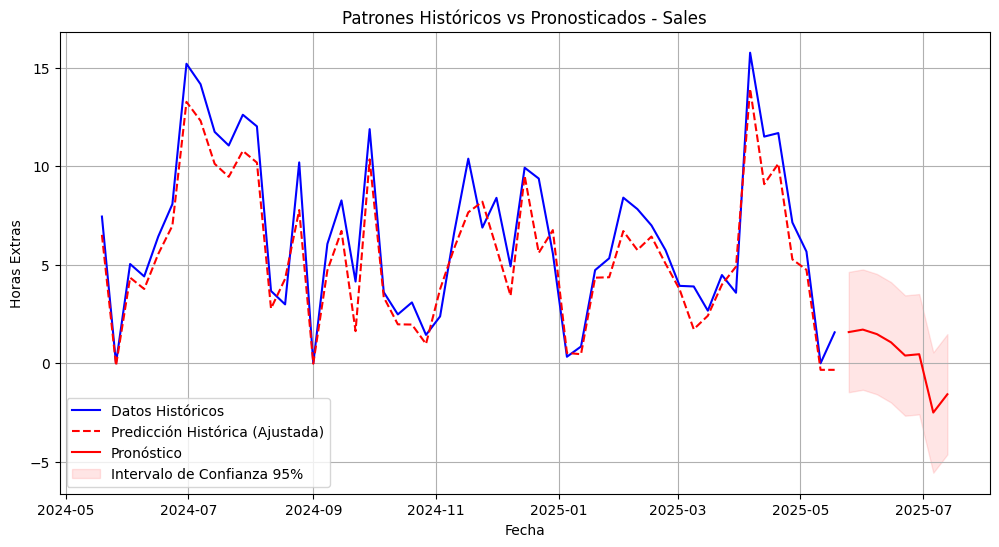

Desplazamiento temporal (lags) para Sales: 0 semanas
Correlación máxima: 732.918060465
Modelo entrenado para Sales: sarima
Orden: (1, 0, 0), Orden Estacional: (0, 0, 1, 13)


Resumen de Modelos Entrenados:
Departamento: Finance, Modelo: sarima, Orden: (1, 0, 0), Orden Estacional: (0, 0, 0, 13)
Departamento: HR, Modelo: sarima, Orden: (3, 1, 1), Orden Estacional: (0, 0, 0, 4)
Departamento: Inventory, Modelo: holt, Orden: None, Orden Estacional: None
Departamento: IT, Modelo: holt, Orden: None, Orden Estacional: None
Departamento: Marketing, Modelo: holt, Orden: None, Orden Estacional: None
Departamento: Sales, Modelo: sarima, Orden: (1, 0, 0), Orden Estacional: (0, 0, 1, 13)


In [13]:
def detect_seasonal_period(series, periods_to_test=[2, 4, 7, 13]):
    """
    Detects the optimal seasonal period with stricter checks for short series.
    """
    if len(series) < 20:
        logging.warning(f"Serie demasiado corta para detectar estacionalidad ({len(series)} puntos). Usando período 2.")
        return 2
    
    if len(series) < 60:
        logging.info(f"Serie corta ({len(series)} puntos). Limitando período estacional a 4.")
        periods_to_test = [p for p in periods_to_test if p <= 13]
    
    best_period = 1
    max_seasonal_std = 0
    for p in periods_to_test:
        try:
            if len(series) >= 2 * p:
                result = seasonal_decompose(series, period=p, extrapolate_trend='freq')
                seasonal_std = result.seasonal.std()
                if seasonal_std > max_seasonal_std:
                    max_seasonal_std = seasonal_std
                    best_period = p
        except Exception as e:
            logging.warning(f"Error detectando estacionalidad con período {p}: {e}")
            continue
    
    logging.info(f"Período estacional seleccionado: {best_period} (std estacional: {max_seasonal_std:.4f})")
    return best_period if max_seasonal_std > 0 and len(series) >= 2 * best_period else 2

def diagnose_residuals(model_fit, dept_data, department):
    """
    Analyzes the residuals of the SARIMA model.
    """
    residuals = model_fit.resid
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    plt.plot(residuals)
    plt.title(f'Residuos - {department}')
    
    plt.subplot(122)
    plot_acf(residuals, lags=20, ax=plt.gca(), title=f'ACF de Residuos - {department}')
    plt.tight_layout()
    plt.show()
    
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(f"Prueba de Ljung-Box para {department}:\n{lb_test}")

def validate_residuals(model_fit, dept_data, max_lags=10, p_value_threshold=0.05):
    """
    Validates if the model residuals are white noise using the Ljung-Box test.
    """
    residuals = model_fit.resid
    lb_test = acorr_ljungbox(residuals, lags=[max_lags], return_df=True)
    p_value = lb_test['lb_pvalue'].iloc[0]
    
    if p_value < p_value_threshold:
        logging.warning(f"Residuos no son ruido blanco para {dept_data['department'].iloc[0]} (p-valor={p_value:.4f})")
        return False
    return True

def evaluate_model_cv(dept_data, model, model_type='sarima', order=None, seasonal_order=None, n_splits=5):
    """
    Performs time series cross-validation.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores, mae_scores = [], []
    
    for train_index, test_index in tscv.split(dept_data):
        train, test = dept_data.iloc[train_index], dept_data.iloc[test_index]
        try:
            if model_type == 'sarima':
                if order is None or seasonal_order is None:
                    raise ValueError("Order and seasonal_order must be provided for SARIMA")
                model_fit = SARIMAX(
                    train['total_overtime'],
                    order=order,
                    seasonal_order=seasonal_order
                ).fit(disp=False)
                predictions = model_fit.forecast(steps=len(test))
            else:  # Holt
                model_fit = Holt(train['total_overtime']).fit()
                predictions = model_fit.forecast(steps=len(test))
            
            predictions = predictions.clip(lower=0)
            rmse = np.sqrt(mean_squared_error(test['total_overtime'], predictions))
            mae = mean_absolute_error(test['total_overtime'], predictions)
            
            rmse_scores.append(rmse)
            mae_scores.append(mae)
        except Exception as e:
            logging.warning(f"Error en validación cruzada para {dept_data['department'].iloc[0]}: {e}")
            continue
    
    if not rmse_scores or not mae_scores:
        logging.error(f"No se pudieron calcular métricas de validación cruzada para {dept_data['department'].iloc[0]}")
        return {
            'mean_rmse': np.inf,
            'mean_mae': np.inf,
            'std_rmse': np.inf,
            'std_mae': np.inf
        }
    
    return {
        'mean_rmse': np.mean(rmse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_rmse': np.std(rmse_scores),
        'std_mae': np.std(mae_scores)
    }

def train_holt(dept_data):
    """
    Trains a Holt model as a fallback.
    """
    try:
        model = Holt(dept_data['total_overtime']).fit()
        cv_metrics = evaluate_model_cv(dept_data, model, model_type='holt')
        print(f"Validación cruzada para {dept_data['department'].iloc[0]} (Holt):")
        print(f"RMSE medio: {cv_metrics['mean_rmse']:.2f}, MAE medio: {cv_metrics['mean_mae']:.2f}")
        return model
    except Exception as e:
        logging.error(f"Error entrenando Holt para {dept_data['department'].iloc[0]}: {e}")
        raise

def train_sarima(dept_data):
    """
    Trains a SARIMA model with residual validation, falling back to Holt with more conditions.
    """
    department = dept_data['department'].iloc[0]
    series = dept_data['total_overtime']
    
    # Condiciones iniciales para switch a Holt
    if len(series) < 30 or series.isna().all() or not np.isfinite(series).all() or series.std() < 1e-5:
        logging.warning(f"Datos insuficientes o baja variabilidad para {department} (longitud={len(series)}, std={series.std():.5f}). Usando Holt.")
        model_fit = train_holt(dept_data)
        return model_fit, 'holt', None, None
    
    # Condición específica para Inventory y departamentos complejos
    if department in ['Inventory', 'IT']:
        if len(series) < 40 or series.var() < 1.0:
            logging.warning(f"{department} tiene datos complejos o insuficientes (longitud={len(series)}, var={series.var():.2f}). Usando Holt.")
            model_fit = train_holt(dept_data)
            return model_fit, 'holt', None, None
    
    try:
        # Detectar período estacional
        seasonal_period = detect_seasonal_period(series)
        print(f"Período estacional para {department}: {seasonal_period}")
        
        # Intentar SARIMA con parámetros iniciales
        model = auto_arima(
            series,
            seasonal=True,
            m=seasonal_period,
            max_p=3, max_q=3, max_d=2,
            max_P=2, max_Q=2, max_D=1,
            maxiter=100,
            stepwise=True,
            trace=False,
            error_action='ignore',
            suppress_warnings=True
        )
        order = model.order
        seasonal_order = (model.seasonal_order[0], model.seasonal_order[1], model.seasonal_order[2], seasonal_period)
        
        # Forzar switch a Holt si el orden es nulo
        if order == (0, 0, 0) and seasonal_order[0] == 0 and seasonal_order[1] == 0 and seasonal_order[2] == 0:
            logging.warning(f"Orden nulo detectado para {department}. Usando Holt.")
            model_fit = train_holt(dept_data)
            return model_fit, 'holt', None, None
        
        model_fit = SARIMAX(
            series,
            order=order,
            seasonal_order=seasonal_order
        ).fit(disp=False)
        
        # Validar residuos
        if validate_residuals(model_fit, dept_data):
            diagnose_residuals(model_fit, dept_data, department)
            cv_metrics = evaluate_model_cv(
                dept_data,
                model_fit,
                model_type='sarima',
                order=order,
                seasonal_order=seasonal_order
            )
            print(f"Validación cruzada para {department} (SARIMA):")
            print(f"RMSE medio: {cv_metrics['mean_rmse']:.2f}, MAE medio: {cv_metrics['mean_mae']:.2f}")
            return model_fit, 'sarima', order, seasonal_order
        else:
            logging.info(f"Reintentando con parámetros más amplios para {department}")
            model = auto_arima(
                series,
                seasonal=True,
                m=seasonal_period,
                max_p=5, max_q=5, max_d=2,
                max_P=3, max_Q=3, max_D=1,
                maxiter=200,
                stepwise=False,
                trace=False,
                error_action='ignore',
                suppress_warnings=True
            )
            order = model.order
            seasonal_order = (model.seasonal_order[0], model.seasonal_order[1], model.seasonal_order[2], seasonal_period)
            
            # Forzar switch a Holt si el orden sigue siendo nulo
            if order == (0, 0, 0) and seasonal_order[0] == 0 and seasonal_order[1] == 0 and seasonal_order[2] == 0:
                logging.warning(f"Orden nulo detectado tras reintento para {department}. Usando Holt.")
                model_fit = train_holt(dept_data)
                return model_fit, 'holt', None, None
            
            model_fit = SARIMAX(
                series,
                order=order,
                seasonal_order=seasonal_order
            ).fit(disp=False)
            
            if validate_residuals(model_fit, dept_data):
                diagnose_residuals(model_fit, dept_data, department)
                cv_metrics = evaluate_model_cv(
                    dept_data,
                    model_fit,
                    model_type='sarima',
                    order=order,
                    seasonal_order=seasonal_order
                )
                print(f"Validación cruzada para {department} (SARIMA):")
                print(f"RMSE medio: {cv_metrics['mean_rmse']:.2f}, MAE medio: {cv_metrics['mean_mae']:.2f}")
                return model_fit, 'sarima', order, seasonal_order
            else:
                logging.warning(f"SARIMA no válido para {department}, usando Holt")
                model_fit = train_holt(dept_data)
                return model_fit, 'holt', None, None
                
    except Exception as e:
        logging.warning(f"Error entrenando SARIMA para {department}: {e}, usando Holt")
        model_fit = train_holt(dept_data)
        return model_fit, 'holt', None, None

def check_pattern_alignment(dept_data, model, model_type, order, seasonal_order, periods=8):
    """
    Checks the alignment between historical and forecasted patterns to detect displacement.
    """
    department = dept_data['department'].iloc[0]
    series = dept_data['total_overtime']
    last_date = dept_data.index[-1]
    
    try:
        if model_type == 'sarima':
            model_fit = SARIMAX(
                series,
                order=order,
                seasonal_order=seasonal_order
            ).fit(disp=False)
            historical_pred = model_fit.predict(start=series.index[0], end=series.index[-1])
            forecast = model_fit.forecast(steps=periods)
        else:
            model_fit = Holt(series).fit()
            historical_pred = model_fit.fittedvalues
            forecast = model_fit.forecast(steps=periods)
        
        # Ajustar las fechas del forecast para empezar desde el último punto histórico
        forecast_dates = pd.date_range(start=last_date, periods=periods + 1, freq='W-SUN')[1:]
        forecast = pd.Series(forecast.values, index=forecast_dates)
        
        # Ajustar historical_pred para compensar el lag inherente del modelo
        historical_pred_shifted = historical_pred.shift(-1).fillna(method='ffill')
        
        # Depuración: Imprimir fechas para verificar alineación
        print(f"Departamento: {department}")
        print(f"Última fecha histórica: {series.index[-1]}")
        print(f"Primera fecha de pronóstico: {forecast.index[0]}")
        print(f"Fechas históricas (primeras 3 y últimas 3): {series.index[:3]} ... {series.index[-3:]}")
        print(f"Fechas de historical_pred (primeras 3 y últimas 3): {historical_pred.index[:3]} ... {historical_pred.index[-3:]}")
        
        # Depuración: Imprimir valores de series y historical_pred
        print(f"Últimos 5 valores de series: {series[-5:]}")
        print(f"Últimos 5 valores de historical_pred (original): {historical_pred[-5:]}")
        print(f"Últimos 5 valores de historical_pred (ajustado): {historical_pred_shifted[-5:]}")
        
        # Gráfica
        plt.figure(figsize=(12, 6))
        plt.plot(series.index, series, label='Datos Históricos', color='blue')
        plt.plot(historical_pred_shifted.index, historical_pred_shifted, label='Predicción Histórica (Ajustada)', linestyle='--', color='red')
        plt.plot(forecast.index, forecast, label='Pronóstico', linestyle='-', color='red')
        plt.fill_between(forecast.index, 
                         forecast - 1.96 * forecast.std(), 
                         forecast + 1.96 * forecast.std(), 
                         color='red', alpha=0.1, label='Intervalo de Confianza 95%')
        plt.title(f'Patrones Históricos vs Pronosticados - {department}')
        plt.xlabel('Fecha')
        plt.ylabel('Horas Extras')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Asegurar que las series estén alineadas antes de calcular correlación
        historical_pred_shifted = historical_pred_shifted.reindex(series.index, method='ffill').fillna(0)
        series_aligned = series.reindex(historical_pred_shifted.index).fillna(0)
        
        # Calcular correlación cruzada
        max_lag_limit = min(len(series_aligned) // 2, 13)
        corr = correlate(series_aligned - series_aligned.mean(), historical_pred_shifted - historical_pred_shifted.mean(), mode='full')
        lags = np.arange(-(len(series_aligned) - 1), len(series_aligned))
        corr = corr[len(series_aligned)-1-max_lag_limit:len(series_aligned)-1+max_lag_limit+1]
        lags = lags[len(series_aligned)-1-max_lag_limit:len(series_aligned)-1+max_lag_limit+1]
        
        # Calcular el lag máximo
        max_lag = lags[np.argmax(np.abs(corr))]
        print(f"Desplazamiento temporal (lags) para {department}: {max_lag} semanas")
        
        # Depuración adicional: Imprimir el lag máximo y el valor de correlación
        print(f"Correlación máxima: {corr[np.argmax(np.abs(corr))]}")
        
    except Exception as e:
        logging.error(f"Error verificando alineación de patrones para {department}: {e}")

def check_department_correlations(historical_data):
    """
    Checks correlations between departments to understand pattern similarities.
    """
    try:
        pivot_data = historical_data.pivot(index='work_date', columns='department', values='total_overtime')
        correlation_matrix = pivot_data.corr()
        print("Matriz de correlación entre departamentos:")
        display(correlation_matrix)
        
        plt.figure(figsize=(12, 6))
        for dept in historical_data['department'].unique():
            dept_data = historical_data[historical_data['department'] == dept]
            plt.plot(dept_data['work_date'], dept_data['total_overtime'], label=dept)
        plt.title("Horas Extras Históricas por Departamento")
        plt.xlabel("Fecha")
        plt.ylabel("Horas Extras")
        plt.legend()
        plt.grid()
        plt.show()
        
    except Exception as e:
        logging.error(f"Error calculando correlaciones entre departamentos: {e}")

# Train models for each department
department_models = {}
department_model_types = {}
department_orders = {}
department_seasonal_orders = {}

# Verificar correlaciones entre departamentos antes de entrenar
check_department_correlations(historical_data)

# Entrenar modelos y verificar alineación de patrones
for department in historical_data['department'].unique():
    try:
        dept_data = historical_data[historical_data['department'] == department].set_index('work_date')
        model, model_type, order, seasonal_order = train_sarima(dept_data)
        department_models[department] = model
        department_model_types[department] = model_type
        department_orders[department] = order
        department_seasonal_orders[department] = seasonal_order
        
        check_pattern_alignment(dept_data, model, model_type, order, seasonal_order, periods=8)
        
        print(f"Modelo entrenado para {department}: {model_type}")
        print(f"Orden: {order}, Orden Estacional: {seasonal_order}\n")
        
    except Exception as e:
        print(f"No se pudo entrenar el modelo para {department}: {e}")
        logging.error(f"No se pudo entrenar el modelo para {department}: {e}")

# Imprimir resumen de modelos entrenados
print("\nResumen de Modelos Entrenados:")
for dept in department_models.keys():
    print(f"Departamento: {dept}, Modelo: {department_model_types[dept]}, Orden: {department_orders[dept]}, Orden Estacional: {department_seasonal_orders[dept]}")

## 6. Generación de Predicciones

Generamos predicciones para las próximas 4 semanas con intervalos de confianza.

In [14]:
def generate_predictions(model, model_type, last_date, periods=4):
    """
    Generates predictions for a given model (SARIMA or Holt).

    Args:
        model: Fitted SARIMA or Holt model.
        model_type (str): Type of model ('sarima' or 'holt').
        last_date (datetime): Last date in the historical data.
        periods (int): Number of periods to forecast (default: 4 weeks).

    Returns:
        pd.DataFrame: DataFrame with columns 'ds', 'yhat', 'yhat_lower', 'yhat_upper'.

    Raises:
        Exception: If prediction generation fails.
    """
    try:
        # Generate prediction dates starting immediately after the last date (weekly, Sundays)
        prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=periods, freq='W-SUN')
        if model_type == 'sarima':
            forecast = model.get_forecast(steps=periods)
            forecast_df = pd.DataFrame({
                'ds': prediction_dates,
                'yhat': forecast.predicted_mean.clip(lower=0),
                'yhat_lower': forecast.conf_int().iloc[:, 0].clip(lower=0),
                'yhat_upper': forecast.conf_int().iloc[:, 1].clip(lower=0)
            })
        else:  # Holt
            forecast = model.forecast(steps=periods).clip(lower=0)
            # Approximate confidence intervals using residual standard deviation
            residuals = model.resid
            std_err = np.std(residuals) if len(residuals) > 0 and not np.isnan(residuals).all() else 1.0
            forecast_df = pd.DataFrame({
                'ds': prediction_dates,
                'yhat': forecast,
                'yhat_lower': forecast - 1.96 * std_err,
                'yhat_upper': forecast + 1.96 * std_err
            })
            forecast_df[['yhat_lower', 'yhat_upper']] = forecast_df[['yhat_lower', 'yhat_upper']].clip(lower=0)
        
        forecast_df.set_index('ds', inplace=True)
        logging.info(f"Predicciones generadas para {model_type.upper()} model")
        return forecast_df
    except Exception as e:
        logging.error(f"Error generando predicciones para {model_type.upper()} model: {e}")
        raise

# Generate predictions for each department
department_forecasts = {}
for department in department_models.keys():
    try:
        dept_data = historical_data[historical_data['department'] == department]
        last_date = dept_data['work_date'].max()
        model_type = department_model_types.get(department, 'sarima')  # Default to sarima if not found
        forecast = generate_predictions(
            department_models[department],
            model_type,
            last_date
        )
        department_forecasts[department] = forecast
        print(f"Predicciones generadas para {department} ({model_type.upper()})")
    except Exception as e:
        print(f"No se pudieron generar predicciones para {department}: {e}")
        logging.error(f"No se pudieron generar predicciones para {department}: {e}")

2025-05-23 20:10:18,700 - INFO - Predicciones generadas para SARIMA model
2025-05-23 20:10:18,737 - INFO - Predicciones generadas para SARIMA model


Predicciones generadas para Finance (SARIMA)
Predicciones generadas para HR (SARIMA)


2025-05-23 20:10:18,896 - INFO - Predicciones generadas para HOLT model
2025-05-23 20:10:19,012 - INFO - Predicciones generadas para HOLT model
2025-05-23 20:10:19,086 - INFO - Predicciones generadas para HOLT model


Predicciones generadas para Inventory (HOLT)
Predicciones generadas para IT (HOLT)


2025-05-23 20:10:19,161 - INFO - Predicciones generadas para SARIMA model


Predicciones generadas para Marketing (HOLT)
Predicciones generadas para Sales (SARIMA)


## 7. Visualización de Predicciones

Creamos gráficos interactivos con Plotly para mostrar datos históricos, predicciones históricas, y pronósticos futuros.

In [15]:
def plot_forecast(department, historical_data, forecast, model_type):
    """
    Creates an interactive Plotly visualization for the forecast.

    Args:
        department (str): Name of the department.
        historical_data (pd.DataFrame): Historical data with columns 'work_date', 'department', 'total_overtime'.
        forecast (pd.DataFrame): Forecast DataFrame with columns 'yhat', 'yhat_lower', 'yhat_upper' and datetime index.
        model_type (str): Type of model ('sarima' or 'holt').

    Returns:
        go.Figure: Plotly figure object.

    Raises:
        Exception: If visualization fails.
    """
    try:
        # Select last 24 weeks of historical data for the department
        hist_dept = historical_data[historical_data['department'] == department].tail(24).copy()
        fig = go.Figure()
        
        # Historical data
        fig.add_trace(
            go.Scatter(
                x=hist_dept['work_date'],
                y=hist_dept['total_overtime'],
                name='Datos Históricos',
                mode='markers+lines',
                line=dict(color='blue'),
                hovertemplate="<b>Fecha:</b> %{x}<br><b>Valor Real:</b> %{y:.1f}<extra></extra>"
            )
        )
        
        # Historical predictions
        model = department_models[department]
        if model_type == 'sarima':
            historical_predictions = model.get_prediction(start=hist_dept['work_date'].min())
            historical_mean = historical_predictions.predicted_mean.clip(lower=0)
        else:  # Holt
            historical_mean = model.fittedvalues.reindex(hist_dept['work_date']).clip(lower=0)
            # Fill any missing values with forward fill
            historical_mean = historical_mean.fillna(method='ffill')
        
        # Ajustar historical_mean para compensar el lag inherente del modelo (como en check_pattern_alignment)
        historical_mean_shifted = historical_mean.shift(-1).fillna(method='ffill')
        
        fig.add_trace(
            go.Scatter(
                x=hist_dept['work_date'],
                y=historical_mean_shifted,
                name='Predicción Histórica',
                mode='lines',
                line=dict(color='red', dash='dash'),
                hovertemplate="<b>Fecha:</b> %{x}<br><b>Predicción:</b> %{y:.1f}<extra></extra>"
            )
        )
        
        # Future forecast
        fig.add_trace(
            go.Scatter(
                x=[hist_dept['work_date'].iloc[-1]] + forecast.index.tolist(),
                y=[historical_mean_shifted.iloc[-1]] + forecast['yhat'].tolist(),
                name='Pronóstico',
                mode='lines',
                line=dict(color='red'),
                hovertemplate="<b>Fecha:</b> %{x}<br><b>Predicción:</b> %{y:.1f}<br>" +
                             "<b>IC Inferior:</b> %{customdata[0]:.1f}<br><b>IC Superior:</b> %{customdata[1]:.1f}<extra></extra>",
                customdata=np.column_stack((
                    [0] + forecast['yhat_lower'].tolist(),
                    [0] + forecast['yhat_upper'].tolist()
                ))
            )
        )
        
        # Confidence interval
        fig.add_trace(
            go.Scatter(
                x=forecast.index.tolist() + forecast.index.tolist()[::-1],
                y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
                fill='toself',
                fillcolor='rgba(211,211,211,0.3)',
                line=dict(color='rgba(255,255,255,0)'),
                name='Intervalo de Confianza 95%',
                showlegend=True,
                hoverinfo='skip'
            )
        )
        
        fig.update_layout(
            title=f'Pronóstico de Horas Extra - {department} ({model_type.upper()})',
            xaxis_title='Fecha',
            yaxis_title='Horas Extra',
            hovermode='x unified',
            showlegend=True,
            template='plotly_white',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=0.5
            )
        )
        
        return fig
    except Exception as e:
        logging.error(f"Error generando visualización para {department} ({model_type.upper()}): {e}")
        raise

# Generate and display visualizations
print("\nGenerando visualizaciones...")
for department in department_forecasts.keys():
    try:
        model_type = department_model_types.get(department, 'sarima')  # Default to sarima if not found
        fig = plot_forecast(
            department,
            historical_data,
            department_forecasts[department],
            model_type
        )
        fig.show()
        print(f"Visualización generada para {department} ({model_type.upper()})")
    except Exception as e:
        print(f"Error generando visualización para {department}: {e}")
        logging.error(f"Error generando visualización para {department}: {e}")
print("\nProceso de visualización completado.")


Generando visualizaciones...


Visualización generada para Finance (SARIMA)


Visualización generada para HR (SARIMA)


Visualización generada para Inventory (HOLT)


Visualización generada para IT (HOLT)


Visualización generada para Marketing (HOLT)


Visualización generada para Sales (SARIMA)

Proceso de visualización completado.


## 8. Guardar Modelo y Predicciones

Almacenamos los modelos en archivos .pkl y las predicciones con métricas en SQL Server.

In [16]:
def calculate_metrics(dept_data, model, model_type):
    """
    Calculates evaluation metrics for the model.

    Args:
        dept_data (pd.DataFrame): Department data with temporal index.
        model: Fitted SARIMA or Holt model.
        model_type (str): Type of model ('sarima' or 'holt').

    Returns:
        dict: Metrics including rmse, mae, smape, mase, and model_quality.
    """
    try:
        if model_type == 'sarima':
            predictions = model.get_prediction(start=dept_data.index[0]).predicted_mean.clip(lower=0)
        else:  # Holt
            predictions = model.fittedvalues.reindex(dept_data.index).clip(lower=0)
            predictions = predictions.fillna(method='ffill')  # Fill missing values
        
        actual = dept_data['total_overtime']
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual, predictions))
        mae = mean_absolute_error(actual, predictions)
        smape = np.mean(2 * np.abs(predictions - actual) / (np.abs(predictions) + np.abs(actual) + 1e-10)) * 100
        naive_forecast = actual.shift(1).fillna(actual.mean())
        mase = mae / mean_absolute_error(actual[1:], naive_forecast[1:]) if naive_forecast.std() > 0 else np.inf
        
        # Determine model quality
        quality = "Bueno" if mae < 3 and smape < 50 else "Aceptable" if mae < 5 else "Pobre"
        
        return {
            'rmse': rmse,
            'mae': mae,
            'smape': smape,
            'mase': mase,
            'quality': quality
        }
    except Exception as e:
        logging.error(f"Error calculando métricas para {dept_data['department'].iloc[0]} ({model_type.upper()}): {e}")
        return {
            'rmse': np.inf,
            'mae': np.inf,
            'smape': np.inf,
            'mase': np.inf,
            'quality': 'Pobre'
        }

def save_predictions():
    """
    Saves models, predictions, and metrics to disk and SQL Server, and generates a summary.

    Returns:
        tuple: (predictions_summary_df, metrics_summary_df) for display.

    Raises:
        Exception: If saving fails.
    """
    os.makedirs('Modelos Entrenados', exist_ok=True)
    timestamp = datetime.datetime.now()
    metrics = {}
    predictions_summary = []
    metrics_summary = []
    
    # Save models and calculate metrics
    for department, model in department_models.items():
        try:
            model_type = department_model_types.get(department, 'sarima')
            model_path = f'Modelos Entrenados/overtime_forecast_model_{department}_{model_type}.pkl'
            joblib.dump(model, model_path)
            print(f"Modelo guardado para {department} ({model_type.upper()}) en: {model_path}")
            
            # Calculate metrics
            dept_data = historical_data[historical_data['department'] == department].set_index('work_date')
            metrics[department] = calculate_metrics(dept_data, model, model_type)
            
            # Collect metrics for summary
            metrics_summary.append({
                'Department': department,
                'Model Type': model_type.upper(),
                'RMSE': metrics[department]['rmse'],
                'MAE': metrics[department]['mae'],
                'SMAPE': metrics[department]['smape'],
                'MASE': metrics[department]['mase'],
                'Model Quality': metrics[department]['quality']
            })
        except Exception as e:
            print(f"Error guardando modelo o calculando métricas para {department}: {e}")
            logging.error(f"Error guardando modelo o calculando métricas para {department}: {e}")
    
    # Save predictions and metrics to database
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        # Create tables if they don’t exist
        cursor.execute("""
            IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = 'Overtime_Predictions')
            CREATE TABLE Overtime_Predictions (
                id INT IDENTITY(1,1) PRIMARY KEY,
                timestamp DATETIME,
                department VARCHAR(100),
                prediction_date DATE,
                predicted_value FLOAT,
                confidence_lower FLOAT,
                confidence_upper FLOAT
            )
        """)
        
        cursor.execute("""
            IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = 'ML_Model_Metrics_Overtime_Predictions')
            CREATE TABLE ML_Model_Metrics_Overtime_Predictions (
                id INT IDENTITY(1,1) PRIMARY KEY,
                timestamp DATETIME,
                department VARCHAR(100),
                rmse FLOAT,
                mae FLOAT,
                smape FLOAT,
                mase FLOAT,
                model_quality VARCHAR(50)
            )
        """)
        
        # Insert predictions and metrics
        for department, forecast in department_forecasts.items():
            try:
                for _, row in forecast.iterrows():
                    cursor.execute("""
                        INSERT INTO Overtime_Predictions 
                        (timestamp, department, prediction_date, predicted_value, confidence_lower, confidence_upper)
                        VALUES (%s, %s, %s, %s, %s, %s)
                    """, (
                        timestamp,
                        department,
                        row.name,  # 'ds' is the index
                        row['yhat'],
                        row['yhat_lower'],
                        row['yhat_upper']
                    ))
                    
                    # Collect predictions for summary
                    predictions_summary.append({
                        'Department': department,
                        'Prediction Date': row.name,
                        'Predicted Value': row['yhat'],
                        'Confidence Lower': row['yhat_lower'],
                        'Confidence Upper': row['yhat_upper']
                    })
                
                metric = metrics.get(department, {
                    'rmse': np.inf,
                    'mae': np.inf,
                    'smape': np.inf,
                    'mase': np.inf,
                    'quality': 'Pobre'
                })
                cursor.execute("""
                    INSERT INTO ML_Model_Metrics_Overtime_Predictions 
                    (timestamp, department, rmse, mae, smape, mase, model_quality)
                    VALUES (%s, %s, %s, %s, %s, %s, %s)
                """, (
                    timestamp,
                    department,
                    metric['rmse'],
                    metric['mae'],
                    metric['smape'],
                    metric['mase'],
                    metric['quality']
                ))
            except Exception as e:
                print(f"Error insertando datos para {department}: {e}")
                logging.error(f"Error insertando datos para {department}: {e}")
        
        conn.commit()
        logging.info("Predicciones y métricas guardadas exitosamente")
        
        # Create summary DataFrames
        predictions_summary_df = pd.DataFrame(predictions_summary)
        metrics_summary_df = pd.DataFrame(metrics_summary)
        
        # Display summary
        print("\n=== Resumen de Modelos y Predicciones ===")
        print("\nModelos y Métricas por Departamento:")
        display(metrics_summary_df)
        
        print("\nValores Predichos con Intervalos de Confianza:")
        display(predictions_summary_df)
        
        return predictions_summary_df, metrics_summary_df
    
    except Exception as e:
        conn.rollback()
        print(f"Error al guardar los datos: {e}")
        logging.error(f"Error al guardar los datos: {e}")
        raise
    finally:
        conn.close()

def verify_tables():
    """
    Verifies the number of records in the database tables.
    """
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        cursor.execute("SELECT COUNT(*) FROM Overtime_Predictions")
        pred_count = cursor.fetchone()[0]
        
        cursor.execute("SELECT COUNT(*) FROM ML_Model_Metrics_Overtime_Predictions")
        metrics_count = cursor.fetchone()[0]
        
        print(f"\nRegistros en Overtime_Predictions: {pred_count}")
        print(f"Registros en ML_Model_Metrics: {metrics_count}")
    except Exception as e:
        print(f"Error verificando tablas: {e}")
        logging.error(f"Error verificando tablas: {e}")
    finally:
        conn.close()

# Execute saving and display summary
try:
    predictions_summary_df, metrics_summary_df = save_predictions()
    print("\nDatos guardados exitosamente en la base de datos.")
except Exception as e:
    print(f"\nError al guardar los datos: {str(e)}")

# Verify tables
verify_tables()

Modelo guardado para Finance (SARIMA) en: Modelos Entrenados/overtime_forecast_model_Finance_sarima.pkl
Modelo guardado para HR (SARIMA) en: Modelos Entrenados/overtime_forecast_model_HR_sarima.pkl
Modelo guardado para Inventory (HOLT) en: Modelos Entrenados/overtime_forecast_model_Inventory_holt.pkl
Modelo guardado para IT (HOLT) en: Modelos Entrenados/overtime_forecast_model_IT_holt.pkl
Modelo guardado para Marketing (HOLT) en: Modelos Entrenados/overtime_forecast_model_Marketing_holt.pkl


2025-05-23 20:10:21,051 - INFO - Conexión a la base de datos exitosa


Modelo guardado para Sales (SARIMA) en: Modelos Entrenados/overtime_forecast_model_Sales_sarima.pkl


2025-05-23 20:10:21,282 - INFO - Predicciones y métricas guardadas exitosamente



=== Resumen de Modelos y Predicciones ===

Modelos y Métricas por Departamento:


,Department,Model Type,RMSE,MAE,SMAPE,MASE,Model Quality
0,Finance,SARIMA,3.647594,2.839186,69.409825,1.005090,Aceptable
1,HR,SARIMA,4.379293,3.495104,76.389426,0.636274,Aceptable
2,Inventory,HOLT,4.067219,3.443643,83.447088,0.980450,Aceptable
3,IT,HOLT,4.428185,3.506928,54.868814,0.890822,Aceptable
4,Marketing,HOLT,4.713922,3.732735,83.641874,0.960094,Aceptable
5,Sales,SARIMA,4.100955,2.984713,64.971070,0.929706,Aceptable



Valores Predichos con Intervalos de Confianza:


,Department,Prediction Date,Predicted Value,Confidence Lower,Confidence Upper
0,Finance,2025-05-25,1.279230,0.000000,8.419141
1,Finance,2025-06-01,1.022769,0.000000,10.164171
2,Finance,2025-06-08,0.817723,0.000000,11.035149
3,Finance,2025-06-15,0.653785,0.000000,11.503269
4,HR,2025-05-25,10.642968,2.559948,18.725988
5,HR,2025-06-01,6.343350,0.000000,14.491018
6,HR,2025-06-08,8.312174,0.164347,16.460001
7,HR,2025-06-15,5.084798,0.000000,13.266871
8,Inventory,2025-05-25,4.380199,0.000000,12.563160
9,Inventory,2025-06-01,4.249819,0.000000,12.432780


2025-05-23 20:10:21,393 - INFO - Conexión a la base de datos exitosa



Datos guardados exitosamente en la base de datos.

Registros en Overtime_Predictions: 120
Registros en ML_Model_Metrics: 30
